In [ ]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from math import pi,sin, cos, exp

from sklearn.datasets import make_moons, make_circles

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from  sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

## Task 1. Decision Rules and Feature Engeneering

В этой задаче цель - визуализировать решающие правила нескольких классификаторов, применяемые к искусственному 2-мерному набору данных, сгенерированному встроенным методом `sklearn.datasets`, называемым `make_moons`. В ячейке ниже мы генерируем набор данных. 

In [ ]:
def make_sunny_moons(n_sun=50, n_moons=100, noise=0.0, sun_radius=1.9, theta=None):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise)
    if not n_sun:
        return X_moons, y_moons
    
    np.random.seed(0xBEEFBAD)
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_sun)
    X_sun = sun_radius * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.5, 0.25])
    X_sun += np.random.normal(scale=noise, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)
    
    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)
    X -= X.mean(axis=0)
    
    if theta is None:
        theta = np.pi / 4
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    X = X @ R
    
    return X, y

X, y = make_sunny_moons(n_sun=150, n_moons=300, noise=0.15)

### Subproblem 1.1. Decision Rule Plotting

Цель: по признакам `X` научиться предсказывать целевую переменную `y`. Для этого будем использовать следующие модели:

* Decision Tree (single!) with small depth ($\leq 4$);
* Random Forest with small number of trees ($\leq 25$) of small depth ($\leq 4$);
* Logistic Regreesion;
* Support Vector Machine with RBF kernel;
* Gaussian Naive Bayes;
* k-Nearest Neighbor Classifier with small number of neighbors (e.g. $3$);

Для всех обученных классификаторов вы должны построить области принятия решений (пример показан под ячейкой). Каждый график должен иметь ** Заголовок **, который содержит имя классификатора и его точность (только ** два ** десятичных знака) в данных. 

Plotting points for the whole dataset..


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(),

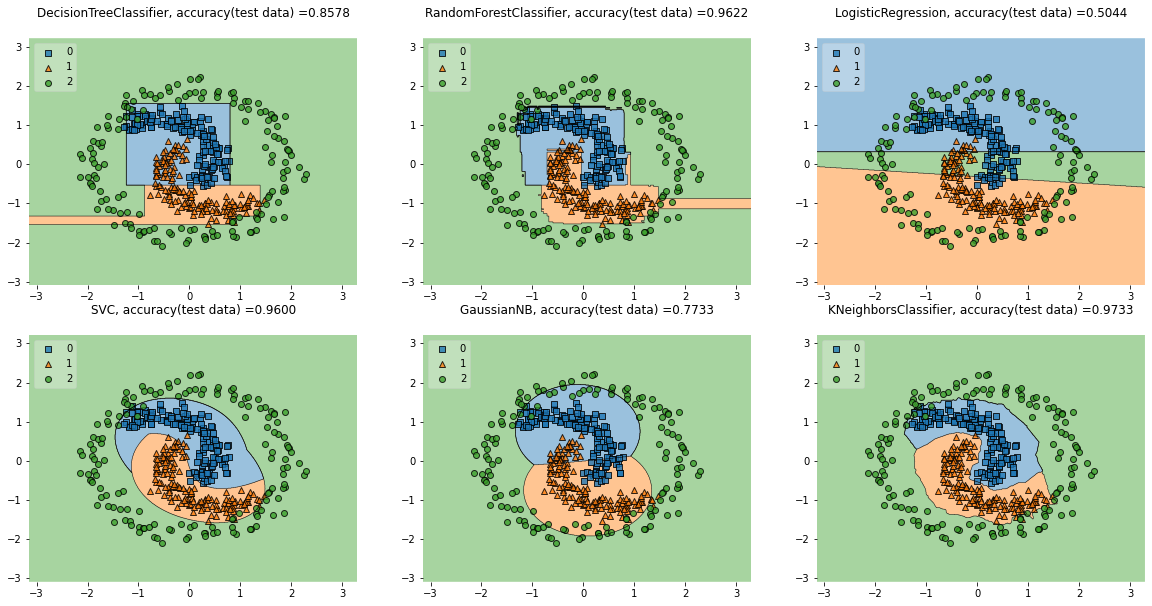

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


def train_classifier(models, classifiers, X, y, all_data = True):
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(ncols=3, nrows=2)
    for i,j,k in zip(models, classifiers, itertools.product([0,1],[0,1, 2])):
        clf = i
        clf.fit(X, y)
        
        ax = plt.subplot(gs[k[0], k[1]])            
        fig = plot_decision_regions(X, y, clf = i, legend=2)
        plt.title(j +', accuracy(test data) =' + '%.4f'% clf.score(X, y)+'\n')

    plt.show()
    
    
#define models and their hyperparams
tree_clf = DecisionTreeClassifier(max_depth = 4, random_state = 42)
forest_clf = RandomForestClassifier(n_estimators = 25, max_depth = 4, random_state = 42)
log_reg = LogisticRegression(random_state=42, penalty = 'l2',
                             multi_class = 'auto', solver = 'lbfgs', max_iter = 500)
svc = SVC(kernel='rbf', gamma='scale')
nb_gauss = GaussianNB()
knn = KNeighborsClassifier(n_neighbors = 3)

models = [tree_clf, forest_clf, log_reg, svc, nb_gauss, knn]
clfs = ['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression',
        'SVC', 'GaussianNB', 'KNeighborsClassifier']

print('Plotting points for the whole dataset..')
train_classifier(models, clfs, X, y)

### END Solution

### Subproblem 1.2. Pipeline: Fitting to Data by Feature Engeneering 
В предыдущей задаче 1.1 несколько классификаторов явно не смогли обучиться на наших данных. Это произошло потому, что решающее правило классификатора имеет ограниченную форму (например, линейная для линейных моделей), в то время как данные оказались сложнее.

Можно попробовать изменить параметры классификатора (например, увеличить количество деревьев в лесу), чтобы повысить точность, но некоторые модели (особенно линейные) не имеют параметров, которые могут изменить форму правила принятия решения. 

В этом случае помогает **feature engeneering**: можно попытаться вычислить новые (например, нелинейные) функции на основе существующего датасета и обучить классификатор с новыми данными. Это может помочь классификаторам с невысокой сложностью соответствовать сложным зависимостям в данных. 

Задача состоит в следующем:
* Выбрать **два классификатора** из предыдущего задания среди: Decision Tree, Random Forest, Naive Bayes, Logistic Regression;
* За счет создания дополнительных функций (например, полиномов) достичь точности $>0.95$.
* Изобразить их правила принятия решений в исходном пространстве признаков. 

Как создавать функции - это ваш выбор. Вы можете создавать собственные атрибуты и добавлять их вручную. Тем не менее, ** настоятельно рекомендуется ** применить следующие встроенные методы `sklearn`: 
* `PolynomialFeatures`, `GaussianRandomProjection` среди прочих - для созданий фичей
* `StandartScaler`, `MinMaxScaler` среди прочих - для масштабирования фичей
* `Pipeline` - для объединения нескольких операций подряд (например, создание фичей и предсказание мо) 

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.random_projection import GaussianRandomProjection
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#Use GridSearchCV for DecisionTreeClassifier to choose optimal values of max_depth and min_samples_split:

parameters = {'max_depth': [i for i in range(1, 20)] ,
              'min_samples_split':[i for i in range(2, 50)]}
tree_clf_ = DecisionTreeClassifier()
tree_clf_ = GridSearchCV(tree_clf_, parameters, cv = 5, iid = False)
tree_clf_.fit(X, y)

print("Best parameters set found on training dataset:")
print(tree_clf_.best_params_)

Best parameters set found on training dataset:
{'max_depth': 6, 'min_samples_split': 2}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Plotting points for the whole dataset in original feature space..


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


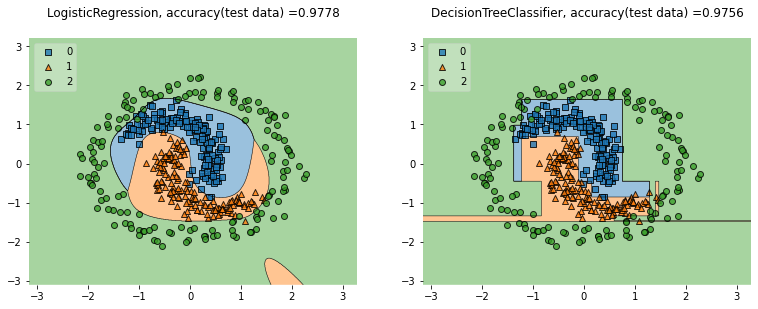

In [15]:
tree_clf_deep = DecisionTreeClassifier(**tree_clf_.best_params_,
                                    random_state = 42)

polynom = PolynomialFeatures(degree=8)
log_reg_polynom = make_pipeline(polynom, log_reg)

models = [log_reg_polynom, tree_clf_deep]
clfs = ['LogisticRegression', 'DecisionTreeClassifier']

print('Plotting points for the whole dataset in original feature space..')
train_classifier(models, clfs, X, y)


## Task 2. Bagging Ensembles of Regressors (2 points)
В этой задаче будет использовать датасет [Concrete Compressive Strength Dataset](https://www.kaggle.com/elikplim/concrete-compressive-strength-data-set).
Ваша цель - определить оптимальные параметры для двух Bagging-Based Forest Ensemble **Regressors** и сравнить их. Давайте загрузим данные и разделим их на тестовую и обучающую части.

In [17]:
data = pd.read_csv('https://raw.githubusercontent.com/ddvika/Data-Science-School-2020/main/lecture_14/data/concrete_data.csv').astype(float)

X = data.drop('concrete_compressive_strength', axis=1)
y = data.concrete_compressive_strength

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

data.sample(3).sort_index()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
475,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3.0,35.36
587,238.2,158.8,0.0,185.7,0.0,1040.6,734.3,28.0,26.91
1022,264.5,111.0,86.5,195.5,5.9,832.6,790.4,28.0,41.54


В этой задаче вы должны рассмотреть модели `RandomForestRegressor` и `ExtraTreesRegressor` для прогнозирования прочности бетона на сжатие (concrete compressive strength) с использованием **squared loss function** (mean squared error). [Extremely Randomized Forest](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf) - один из видов bootstraped forest с простым алгоритмом построения дерева. ExtraTreesRegressor обучает ряд рандомизированных деревьев решений (также называемых дополнительными деревьями) на различных подвыборках набора данных и использует усреднение для повышения точности прогнозов и контроля процесса переобучения. 

Сейчас необходимо проделать следующие шаги и ответить на следующие вопросы:

* Для обоих лесов выполните Grid Search (по train data) по наиболее важным параметрам алгоритма (каким именно?), Чтобы определить оптимальные гиперпараметры.
*  Для получения оптимальных параметров выведите  train, validation score, и test score.
* Сравните полученные оценки. Объясните, почему оценки сильно различаются при обучении и проверке / тестировании.
* Какой из алгоритмов лучше работает на обучающей выборке? Объяснить почему

In [18]:
### BEGIN Solution

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from numpy import mean

parameters_rfr = {'n_estimators': [100, 200, 300, 400],
               'max_features': ['auto'],
               'max_depth': [10, 20, 25],
               'min_samples_split': [2, 4, 6, 8],
               'min_samples_leaf': [2,4],
               'bootstrap': [True]}


RFR = RandomForestRegressor(random_state=2, criterion='mse')
rgr = GridSearchCV(RFR, parameters_rfr, cv = 5, iid = True)
rgr.fit(X_train, y_train)

print("Best parameters set found on training dataset for RandomForestRegressor:")
print(rgr.best_params_)
print()
print('best RF scored on CV(Mean cross-validated score of the best_estimator): ', '%.2f' % rgr.best_score_)


ETR = ExtraTreesRegressor(random_state=2, criterion='mse')
etr = GridSearchCV(ETR, parameters_rfr, cv = 5, iid = True)
etr.fit(X_train, y_train)
print("Best parameters set found on training dataset for ExtraTreesRegressor:")
print(etr.best_params_)
print()
print('best RF scored on CV(Mean cross-validated score of the best_estimator): ', '%.2f' % etr.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameters set found on training dataset for RandomForestRegressor:
{'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

best RF scored on CV(Mean cross-validated score of the best_estimator):  0.90


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameters set found on training dataset for ExtraTreesRegressor:
{'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}

best RF scored on CV(Mean cross-validated score of the best_estimator):  0.89


In [19]:
RFR = RandomForestRegressor(**rgr.best_params_)
RFR.fit(X_train, y_train)


ETR = ExtraTreesRegressor(**etr.best_params_)
ETR.fit(X_train, y_train)

print('Ensemble Classifier', '\t', 'Train', '\t', 'Valid','\t', 'Test')
print('RandomForestRegressor', '\t',
      '%.3f'% RFR.score(X_train, y_train),'\t',
      '%.3f' % mean(cross_val_score(RFR, X_train, y_train, cv=5)), '\t',
      '%.3f'% RFR.score(X_test, y_test))

print('ExtraTreesRegressor', '\t',
      '%.3f'% ETR.score(X_train, y_train),'\t',
      '%.3f' % mean(cross_val_score(ETR, X_train, y_train, cv=5)), '\t',
      '%.3f'% ETR.score(X_test, y_test))

#Explanation for scores: it seems that both of our our models overfitted - as score on train set is rather higher than
# on validation and test ones. RandomForestRegressor seems to behave a little bit better,
# however for some set of hyperparameters (found while testing GridSearchCV) ExtraTreesRegressor showed better results.
# ExtraTreesRegressor is a bit worse when there is a high number of noisy features, also it tries to control
# overfitting, that is why the score on train is closer(a little bit) to the test score.

### END Solution

Ensemble Classifier 	 Train 	 Valid 	 Test
RandomForestRegressor 	 0.974 	 0.895 	 0.897
ExtraTreesRegressor 	 0.961 	 0.890 	 0.893


## Task 3. Multi-Class Classification Strategies (2 points)
В этой задаче вы имеете дело с многоклассовой классификацией для [Glass Classification Data](https://www.kaggle.com/uciml/glass).

In [23]:
data = pd.read_csv('https://raw.githubusercontent.com/ddvika/Data-Science-School-2020/main/lecture_14/data/glass.csv')
X, y = data.drop('Type', axis=1), data.Type
data.sample(3)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
45,1.51900,13.49,3.48,1.35,71.95,0.55,9.00,0.0,0.00,1
19,1.51735,13.02,3.54,1.69,72.73,0.54,8.44,0.0,0.07,1
56,1.51215,12.99,3.47,1.12,72.98,0.62,8.35,0.0,0.31,1


In [24]:
data

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Характеристики (фичи) каждого стеклянного объекта соответствуют доле конкретного химического элемента в объекте. Целевая переменная соответствует типу стекла (6 классов). 

В этой задаче вы должны эмпирически сравнить временную сложность и производительность нескольких стратегий мультиклассовой разметки (multicalass labelling) для разных алгоритмов. Будем использовать следующие алгоритмы: 
* Single Decision Tree (depth 7)
* Medium Random Forest (100 trees of depth 3)
* KNearestNeighbors (5 neighbors)
* Logistic Regression

Обратите внимание, что все эти алгоритмы по умолчанию поддерживают **мультиклассовую маркировку**. Тем не менее, мы хотим сравнить этот подход с подходами **OneVSRest** и **OneVSOne**, применяемыми к этим алгоритмам. Точнее, для каждой пары (алгоритма, подхода) вы должны выполнить 5-кратную перекрестную проверку данных и вывести оценку и время вычисления в виде **таблицы**. Обратите внимание, что вам также необходимо самостоятельно выбрать метрику для оптимизации во время CV (например, точность, сбалансированная точность). 

После этого ответьте на следующие вопросы:
* Какой показатель вы выбрали для оптимизации во время перекрестной проверки и почему? Объясните
* Для каких алгоритмов использование подхода OneVSRest / OneVSOne обеспечивает лучшую производительность без значительного увеличения времени вычислений? 

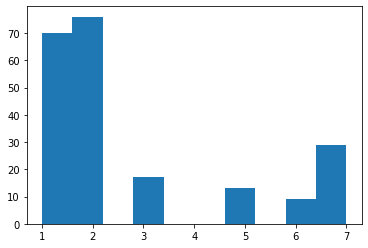

In [25]:
### BEGIN Solution
#Let's plot class distribution
plt.hist(data['Type'])
plt.show()

Что можете сказать о распределении классов?

При перекрестной проверке стоит использвать 'accuracy' или 'balanced_accuracy'?

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from numpy import mean
import time

names = ["Logistic", "Random Forest", "KNN", "Decision Tree"]


classifiers = [
    LogisticRegression(random_state = 2, solver = 'lbfgs', max_iter = 5000, multi_class = 'auto'),
    RandomForestClassifier(max_depth=3, n_estimators=100, random_state = 2),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(max_depth=5, random_state = 2)]

def train_clfs(classifiers, X, y):
    scoring = 'balanced_accuracy'
    time_multi, time_ovr, time_ovo = [], [], []
    scores_multi_val, scores_ovr_val, scores_ovo_val = [], [], []
    
    for model in classifiers:
        
        start = time.time()
        score = mean(cross_val_score(model, X, y, cv=5, scoring = scoring))
        stop  = time.time()
        time_multi.append(stop-start)
        scores_multi_val.append(score)
        
        start = time.time()
        score = mean(cross_val_score(OneVsRestClassifier(model), X, y, cv=5, scoring = scoring))
        stop  = time.time()
        time_ovr.append(stop-start)
        scores_ovr_val.append(score)
        
        start = time.time()        
        score = mean(cross_val_score(OneVsOneClassifier(model), X, y, cv=5, scoring = scoring))
        stop  = time.time()
        time_ovo.append(stop-start)
        scores_ovo_val.append(score)
        
    times = [time_multi, time_ovr, time_ovo]
    scores_val = [scores_multi_val, scores_ovr_val, scores_ovo_val]
        
    return times, scores_val


#Train models
time, scores_val = train_clfs(classifiers, X, y)


#display results
from IPython.display import display, HTML

print("Cross Validation Scores")
df_val = pd.DataFrame(scores_val, 
               columns =['LogReg', 'Random Forest','K Nearest Neighbors', 'Decision Tree']) 
df_val = df_val.set_index([pd.Index(['Multiclass', 'OneVsRest', 'OneVsOne'])])
display(df_val)

print("Training Duration (CV=5)")
df = pd.DataFrame(time, 
               columns =['LogReg', 'Random Forest','K Nearest Neighbors', 'Decision Tree']) 
df = df.set_index([pd.Index(['Multiclass', 'OneVsRest', 'OneVsOne'])])

display(HTML(df.to_html()))

Cross Validation Scores


,LogReg,Random Forest,K Nearest Neighbors,Decision Tree
Multiclass,0.444841,0.429028,0.551071,0.544563
OneVsRest,0.421964,0.566349,0.575159,0.538948
OneVsOne,0.429464,0.603810,0.554921,0.682341


Training Duration (CV=5)


,LogReg,Random Forest,K Nearest Neighbors,Decision Tree
Multiclass,1.564333,0.848885,0.028901,0.019929
OneVsRest,1.093911,4.904991,0.097925,0.103096
OneVsOne,2.324666,12.370483,0.379451,0.184553
